In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from spacy.lang.en import English
import string
from spacy.util import minibatch
import random
import spacy
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# from models import InferSent

import tensorflow as tf
import tensorflow_hub as hub

import xgboost as xgb
from sklearn import neighbors

### Data loading

In [4]:
header_list = ['tweet_id', 'user_id', 'bullying_traces', 'type', 'form', 'teasing', 'author_role', 'emotion']
csv = pd.read_csv("data.csv", names=header_list)

### Examination of dataset

In [5]:
csv.shape

(7321, 8)

In [6]:
# prikaz skupa za treniranje
csv.head()

,tweet_id,user_id,bullying_traces,type,form,teasing,author_role,emotion
0,105730486382497793,322329899,y,self-disclosure,other,n,victim,none
1,107688644067856384,185389094,y,self-disclosure,other,n,defender,empathy
2,108654820042354688,361869056,n,NaN,NaN,NaN,NaN,NaN
3,102206417217392640,226320672,n,NaN,NaN,NaN,NaN,NaN
4,102779484725448704,297557032,n,NaN,NaN,NaN,NaN,NaN


### Feature description

* **tweet_id** - Tweet identification number
* **user_id** - User identification number
* **bullying_traces** - Boolean value that says if tweet id a bullying trace
* **type** - Type of bullying(accusation, cyberbullying, denial, report, self-disclosure, NA)
* **form** - Form of bullying(cyberbullying, physical, property damage, relational, verbal, other, NA)
* **teasing** - Boolean that says if teasing is involved
* **author_role** - Author role in a tweet(accuser, assistant, bully, defender, reinforcer, reporter, victim, other, NA)
* **emotion** - Emotion expressed in a tweet(anger, embarrassment, empathy, fear, none, other, pride, relief, sadness, NA)

In [7]:
display(csv.isna().sum())

tweet_id              0
user_id               0
bullying_traces       0
type               5219
form               5219
teasing            5219
author_role        5219
emotion            5219
dtype: int64

In [8]:
csv.describe()

,tweet_id,user_id
count,7.321000e+03,7.321000e+03
mean,1.033140e+17,1.709711e+08
std,3.121057e+15,1.062885e+08
min,9.970695e+16,7.794510e+05
25%,1.000126e+17,7.045550e+07
50%,1.029122e+17,1.644135e+08
75%,1.061250e+17,2.646067e+08
max,1.091281e+17,3.652028e+08


In [9]:
csv.nunique()

tweet_id           7298
user_id            7043
bullying_traces       2
type                  5
form                  6
teasing               2
author_role           8
emotion               9
dtype: int64

In [10]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7321 entries, 0 to 7320
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         7321 non-null   int64 
 1   user_id          7321 non-null   int64 
 2   bullying_traces  7321 non-null   object
 3   type             2102 non-null   object
 4   form             2102 non-null   object
 5   teasing          2102 non-null   object
 6   author_role      2102 non-null   object
 7   emotion          2102 non-null   object
dtypes: int64(2), object(6)
memory usage: 457.7+ KB


In [11]:
csv

,tweet_id,user_id,bullying_traces,type,form,teasing,author_role,emotion
0,105730486382497793,322329899,y,self-disclosure,other,n,victim,none
1,107688644067856384,185389094,y,self-disclosure,other,n,defender,empathy
2,108654820042354688,361869056,n,NaN,NaN,NaN,NaN,NaN
3,102206417217392640,226320672,n,NaN,NaN,NaN,NaN,NaN
4,102779484725448704,297557032,n,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
7316,99912247060611074,162589166,y,self-disclosure,other,n,defender,empathy
7317,99878062220517376,221054960,y,accusation,other,n,accuser,none
7318,100049839949221889,110032215,n,NaN,NaN,NaN,NaN,NaN
7319,100006640492875776,171842492,y,denial,other,n,bully,none


### Tweet overview

In [12]:
import json


f = open('tweet.json')
tweets = json.load(f)

counter = 0
for tweet in tweets:
    counter += 1
    print(tweet['text'])
    
    if counter == 5:
        break

@Underwalt @MsShandraRae @kateplusmy8 mr. walt, stop being a bully.
【自動post】BULLY（いじめ）とSUICIDE（自殺）で、BULLYCIDE（いじめ自殺）。もっとも、自殺するのは憎い相手を殺した後。死なばもろとも…ってところかしら
Paula, Kiersten and LJ's song about bullying. Great job! (Uploading more videos now.) http://fb.me/ASIm1gw1
@katie_ogden @boybandslut @StephWall27 @BAMitsSHAZ @xstephhh_ I was not bullying her! She's trying to steal Jean Martyn from meee! :'( xx
cara3: bully iam gara2 uda di ucpin tpi gk bls


In [13]:
tweets[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'lang'])

### Maybe important features: 
* **text** 
* **symbols** 
* **in_reply_to_status_id**
* **in_reply_to_user_id**
* **description**
* **retweet_count**
* **retweeted**
* **favorite_count**
* **favorited**
* **lang**


In [2]:
# eng_tweets = []
# eng_tweet_ids = []
# for tweet in tweets:
#     if tweet['lang'] == 'en':
#         eng_tweets.append(tweet)
#         eng_tweet_ids.append(tweet['id'])
        
        
# print(f'Number of tweets:{len(tweets)}')        
# print(f'Number of english tweets:{len(eng_tweets)}')
#  # here we filter out non english tweets
# eng_tweets_csv = csv.loc[csv["tweet_id"].isin(eng_tweet_ids)]
# eng_tweets_csv['tweet_text'] = ''   
# eng_tweets_csv['bullying_traces'].value_counts()

In [3]:
# for tweet in eng_tweets:
#     eng_tweets_csv.loc[eng_tweets_csv['tweet_id'] == tweet['id'],'tweet_text'] = tweet['text']

#### Tweet normalization

In [4]:
# from emoji import demojize
# from nltk.tokenize import TweetTokenizer


# tokenizer = TweetTokenizer()


# def normalizeToken(token):
#     lowercased_token = token.lower()
#     if token.startswith("@"):
#         return "@USER"
#     elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
#         return "HTTPURL"
#     elif len(token) == 1:
#         return demojize(token)
#     else:
#         if token == "’":
#             return "'"
#         elif token == "…":
#             return "..."
#         else:
#             return token


# def normalizeTweet(tweet):
#     tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
#     normTweet = " ".join([normalizeToken(token) for token in tokens])

#     normTweet = (
#         normTweet.replace("cannot ", "can not ")
#         .replace("n't ", " n't ")
#         .replace("n 't ", " n't ")
#         .replace("ca n't", "can't")
#         .replace("ai n't", "ain't")
#     )
#     normTweet = (
#         normTweet.replace("'m ", " 'm ")
#         .replace("'re ", " 're ")
#         .replace("'s ", " 's ")
#         .replace("'ll ", " 'll ")
#         .replace("'d ", " 'd ")
#         .replace("'ve ", " 've ")
#     )
#     normTweet = (
#         normTweet.replace(" p . m .", "  p.m.")
#         .replace(" p . m ", " p.m ")
#         .replace(" a . m .", " a.m.")
#         .replace(" a . m ", " a.m ")
#     )

#     return " ".join(normTweet.split())



# print(
#     normalizeTweet(
#         "SC has first two presumptive cases of coronavirus, DHEC confirms https://postandcourier.com/health/covid19/sc-has-first-two-presumptive-cases-of-coronavirus-dhec-confirms/article_bddfe4ae-5fd3-11ea-9ce4-5f495366cee6.html?utm_medium=social&utm_source=twitter&utm_campaign=user-share… via @postandcourier"
#     )
# )

In [5]:
# for index, row in eng_tweets_csv.iterrows():
#     eng_tweets_csv.loc[index,'tweet_text'] = normalizeTweet(eng_tweets_csv.loc[index,'tweet_text'])

# from pathlib import Path  
# filepath = Path('eng_tweets.csv')
# eng_tweets_csv.to_csv(filepath) 

In [6]:
eng_tweets_csv = pd.read_csv("eng_tweets.csv")
eng_tweets_csv = eng_tweets_csv.drop('Unnamed: 0',1)
eng_tweets_csv

C:\Users\ana\AppData\Local\Temp\ipykernel_2092\1460274815.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  eng_tweets_csv = eng_tweets_csv.drop('Unnamed: 0',1)


,tweet_id,user_id,bullying_traces,type,form,teasing,author_role,emotion,tweet_text
0,107688644067856384,185389094,y,self-disclosure,other,n,defender,empathy,@USER i herd that you got bullied when you was...
1,102779484725448704,297557032,n,NaN,NaN,NaN,NaN,NaN,The Bully at School Goes High Tech – Part 1 : ...
2,109034091743154176,177913822,n,NaN,NaN,NaN,NaN,NaN,"@USER @USER @USER Hello , since when i got bul..."
3,102533497637437441,70412906,y,report,other,n,reporter,none,For those keeping score at home - cousin who j...
4,103679008855691264,11363462,n,NaN,NaN,NaN,NaN,NaN,"BETTER ANTI-BULLYING AD SLOGANS : Hey , Bullie..."
...,...,...,...,...,...,...,...,...,...
2517,99823454777393152,48203749,n,NaN,NaN,NaN,NaN,NaN,Confessions of a Cheating Teacher : “ It 's ea...
2518,100063708629319680,305258003,n,NaN,NaN,NaN,NaN,NaN,#NEWMUSIC @USER - BULLY'S #Indie #HipHop #Rap ...
2519,99886032048226304,21235814,n,NaN,NaN,NaN,NaN,NaN,@USER TRB Two is great as well . I love ' Bull...
2520,100006640492875776,171842492,y,denial,other,n,bully,none,@USER @USER do n't call me a bully when you ar...


#### BERT feature extraction

In [25]:
# import torch
# from transformers import AutoModel, AutoTokenizer 

# bertweet = AutoModel.from_pretrained("vinai/bertweet-large")

# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

# # INPUT TWEET IS ALREADY NORMALIZED!
# line = "DHEC confirms HTTPURL via @USER :crying_face:"

# input_ids = torch.tensor([tokenizer.encode(line)])

# with torch.no_grad():
#     features = bertweet(input_ids)  # Models outputs are now tuples
    
# # With TensorFlow 2.0+:
# from transformers import TFAutoModel
# bertweet = TFAutoModel.from_pretrained("vinai/bertweet-large")

Some weights of the model checkpoint at vinai/bertweet-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use 

In [26]:
#print('vector size for each word:',len(features[0][0][0]))

vector size for each word: 1024


#### Preparing the training data

In [38]:
# # Normalizing the tweets
# import copy
# normalized_tweets = copy.deepcopy(eng_tweets)
# for i in range(len(eng_tweets)):
#     normalized_tweets[i]['text'] = normalizeTweet(normalized_tweets[i]['text'])

# counter = 0
# for tweet in normalized_tweets:
#     counter += 1
#     print(tweet['text'])
    
#     if counter == 5:
#         break    

@USER @USER @USER mr . walt , stop being a bully .
Paula , Kiersten and LJ 's song about bullying . Great job ! ( Uploading more videos now . ) HTTPURL
@USER @USER @USER @USER @USER I was not bullying her ! She 's trying to steal Jean Martyn from meee ! :'( xx
This is actually bullying , I want Wenger to watch this and fucking hold every piece of criticism that comes ! #RAGE
If I 'm not happy with my classes this week , I 'm gonna take the role as a bully and be an asshole . Watch out lower-classmen . It will be ugly .


In [23]:
# getting label for tweet
# eng_tweets_csv.loc[eng_tweets_csv["tweet_id"]==eng_tweets[1]['id']]['bullying_traces'].values[0]

'n'

In [57]:
# x = []
# y = []

# for tweet in normalized_tweets:
#     y.append(eng_tweets_csv.loc[eng_tweets_csv["tweet_id"]==tweet['id']]['bullying_traces'].values[0])
#     input_ids = torch.tensor([tokenizer.encode(tweet['text'])])

#     with torch.no_grad():
#         features = bertweet(input_ids)
#         x.append(features)

# # saving x i y
# with open('x_instances.pkl', 'wb') as f:
#     pickle.dump(x, f)
# with open('y_instances.pkl', 'wb') as f:
#     pickle.dump(y, f)

In [7]:
# loading x and y
with open('x_instances.pkl', 'rb') as f:
    x = pickle.load(f)
with open('y_instances.pkl', 'rb') as f:
    y = pickle.load(f)

In [13]:
# max_length = 0
# for item in x:
#     if len(item) > max_length:
#         max_length = len(item)
        
# for i in range(len(x)):
#     if len(x[i]) < max_length:
#         for j in range(max_length - len(x[i])):
#             x[i] = torch.cat((x[i], torch.zeros(1,1024)), 0)

In [13]:
# for i in range(len(x)):
#     x[i] =  x[i].last_hidden_state[0]

In [12]:
# # split the data in train and test
# train_test_ratio = 0.8
# train_size = int(0.8 * len(x))

# x_train = x[0:train_size]
# x_test = x[train_size:]

# y_train = y[0:train_size]
# y_test = y[train_size:]

In [13]:
# len(x) - train_size

505

# ANALYSIS OF DIFFERENT SENTENCE EMBEDDINGS

1. BerTweet
2. TF-IDF
3. BoW
4. Doc2Vec
5. Universal sentence encoder
6. InferSent

## BerTweet

In [8]:
# split the data in train and test for baseline
train_test_ratio = 0.8
train_size = int(0.8 * len(x))

x_train_baseline = []
for i in range(train_size):
    x_train_baseline.append((x[i].reshape(1,-1)[0].detach().numpy()))
x_train_baseline = np.array(x_train_baseline)
    
x_test_baseline = []
for i in range(train_size,len(x)):
    x_test_baseline.append(x[i].reshape(1,-1)[0].detach().numpy())
x_test_baseline = np.array(x_test_baseline)    

y_train_baseline = []
for i in range(train_size):
    if y[i] == 'y':
        y_train_baseline.append(1)
    else:
        y_train_baseline.append(0)
y_train_baseline = np.array(y_train_baseline)
    
y_test_baseline = []
for i in range(train_size,len(y)):
    if y[i] == 'y':
        y_test_baseline.append(1)
    else:
        y_test_baseline.append(0)
y_test_baseline = np.array(y_test_baseline)   

##### Logistic regression

In [9]:
clf = LogisticRegression(random_state=0).fit(x_train_baseline, y_train_baseline)

C:\Users\ana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [227]:
y_pred_baseline_logReg = clf.predict(x_test_baseline)
print(classification_report(y_test_baseline, y_pred_baseline_logReg))
print(accuracy_score(y_test_baseline, y_pred_baseline_logReg))
print(confusion_matrix(y_test_baseline, y_pred_baseline_logReg))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       280
           1       0.74      0.67      0.71       225

    accuracy                           0.75       505
   macro avg       0.75      0.74      0.74       505
weighted avg       0.75      0.75      0.75       505

0.7504950495049505
[[228  52]
 [ 74 151]]


##### XGBoost

In [ ]:
xgb_cl = xgb.XGBClassifier()

In [ ]:
xgb_cl.fit(x_train_baseline, y_train_baseline)

In [27]:
ypred = xgb_cl.predict(x_test_baseline)
print(classification_report(y_test_baseline, ypred))
print(accuracy_score(y_test_baseline, ypred))
print(confusion_matrix(y_test_baseline, ypred))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       280
           1       0.72      0.61      0.66       225

    accuracy                           0.72       505
   macro avg       0.72      0.71      0.71       505
weighted avg       0.72      0.72      0.72       505

0.7207920792079208
[[227  53]
 [ 88 137]]


### KNN

In [74]:
n_neighbors = 5
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x_train_baseline, y_train_baseline)

KNeighborsClassifier(weights='distance')

In [75]:
ypred = clf.predict(x_test_baseline)
print(classification_report(y_test_baseline, ypred))
print(accuracy_score(y_test_baseline, ypred))
print(confusion_matrix(y_test_baseline, ypred))

              precision    recall  f1-score   support

           0       0.67      0.72      0.69       280
           1       0.61      0.56      0.58       225

    accuracy                           0.65       505
   macro avg       0.64      0.64      0.64       505
weighted avg       0.64      0.65      0.64       505

0.6455445544554456
[[201  79]
 [100 125]]


## TF-IDF

In [50]:
train_size = int(0.8 * len(eng_tweets_csv))
test_size = len(eng_tweets_csv) - train_size

v1 = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=4921)
v2 = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True)

In [51]:
x_train = v1.fit_transform(eng_tweets_csv['tweet_text'][0:train_size])
x_test = v2.fit_transform(eng_tweets_csv['tweet_text'][train_size:])

y_train = eng_tweets_csv['bullying_traces'][0:train_size]
y_test = eng_tweets_csv['bullying_traces'][train_size:]

#### Logistic regression

In [69]:
clf = LogisticRegression(random_state=100).fit(x_train, y_train)

In [70]:
y_pred_logReg = clf.predict(x_test)
print(classification_report(y_test, y_pred_logReg))
print(accuracy_score(y_test, y_pred_logReg))
print(confusion_matrix(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           n       0.56      0.99      0.72       281
           y       0.67      0.02      0.03       224

    accuracy                           0.56       505
   macro avg       0.61      0.51      0.38       505
weighted avg       0.61      0.56      0.41       505

0.5603960396039604
[[279   2]
 [220   4]]


#### XGBoost

In [104]:
y_train_xgb = []
y_test_xgb = []
for i in range(len(y_train)):
    if i < len(y_test):
        if y_test[i + train_size] == 'y':
            y_test_xgb.append(1)
        else:
            y_test_xgb.append(0)
        
    if y_train[i] == 'y':
        y_train_xgb.append(1)
    else:
        y_train_xgb.append(0)

In [108]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [109]:
ypred = xgb_cl.predict(x_test)
print(classification_report(y_test_xgb, ypred))
print(accuracy_score(y_test_xgb, ypred))
print(confusion_matrix(y_test_xgb, ypred))

              precision    recall  f1-score   support

           0       0.56      0.96      0.70       281
           1       0.45      0.04      0.07       224

    accuracy                           0.55       505
   macro avg       0.50      0.50      0.39       505
weighted avg       0.51      0.55      0.42       505

0.5524752475247525
[[270  11]
 [215   9]]


### KNN

In [96]:
n_neighbors = 300
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=300, weights='distance')

In [97]:
ypred = clf.predict(x_test)
print(classification_report(y_test, ypred))
print(accuracy_score(y_test, ypred))
print(confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           n       0.56      1.00      0.72       281
           y       0.67      0.01      0.02       224

    accuracy                           0.56       505
   macro avg       0.61      0.50      0.37       505
weighted avg       0.61      0.56      0.41       505

0.5584158415841585
[[280   1]
 [222   2]]


## BoW

In [98]:
c1 = CountVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True, max_features=4921)
c2 = CountVectorizer(stop_words='english', ngram_range=(1, 2), lowercase=True)

In [99]:
x_train = c1.fit_transform(eng_tweets_csv['tweet_text'][0:train_size])
x_test = c2.fit_transform(eng_tweets_csv['tweet_text'][train_size:])

y_train = eng_tweets_csv['bullying_traces'][0:train_size]
y_test = eng_tweets_csv['bullying_traces'][train_size:]

#### Logistic regression

In [122]:
clf = LogisticRegression(random_state=100).fit(x_train, y_train)

In [123]:
y_pred_logReg = clf.predict(x_test)
print(classification_report(y_test, y_pred_logReg))
print(accuracy_score(y_test, y_pred_logReg))
print(confusion_matrix(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           n       0.58      0.86      0.70       281
           y       0.57      0.22      0.32       224

    accuracy                           0.58       505
   macro avg       0.58      0.54      0.51       505
weighted avg       0.58      0.58      0.53       505

0.5801980198019802
[[243  38]
 [174  50]]


#### XGBoost

In [124]:
y_train_xgb = []
y_test_xgb = []
for i in range(len(y_train)):
    if i < len(y_test):
        if y_test[i + train_size] == 'y':
            y_test_xgb.append(1)
        else:
            y_test_xgb.append(0)
        
    if y_train[i] == 'y':
        y_train_xgb.append(1)
    else:
        y_train_xgb.append(0)

In [127]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [128]:
ypred = xgb_cl.predict(x_test)
print(classification_report(y_test_xgb, ypred))
print(accuracy_score(y_test_xgb, ypred))
print(confusion_matrix(y_test_xgb, ypred))

              precision    recall  f1-score   support

           0       0.56      0.97      0.71       281
           1       0.47      0.04      0.07       224

    accuracy                           0.55       505
   macro avg       0.51      0.50      0.39       505
weighted avg       0.52      0.55      0.42       505

0.5544554455445545
[[272   9]
 [216   8]]


### KNN

In [112]:
n_neighbors = 400
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=400, weights='distance')

In [113]:
ypred = clf.predict(x_test)
print(classification_report(y_test, ypred))
print(accuracy_score(y_test, ypred))
print(confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           n       0.56      1.00      0.72       281
           y       1.00      0.00      0.01       224

    accuracy                           0.56       505
   macro avg       0.78      0.50      0.36       505
weighted avg       0.75      0.56      0.40       505

0.5584158415841585
[[281   0]
 [223   1]]


#### PCA with BERTweet

In [10]:
condensed_vector = []
sentence_length = len(x[0])
for vec in x:
    accumulated_vec = torch.zeros(1024)
    for item in vec:
        accumulated_vec += item
    accumulated_vec /= sentence_length
    condensed_vector.append(accumulated_vec.detach().numpy())

In [11]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(condensed_vector)

In [12]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([0.86285438, 0.01453287, 0.00734052])

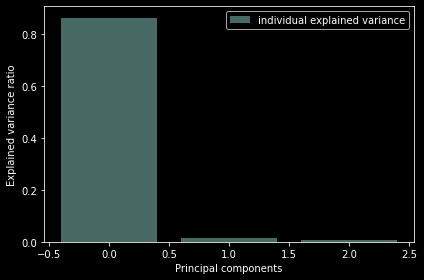

In [252]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [253]:
principalDf = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2','principal component 3'])

In [254]:
principalDf

,principal component 1,principal component 2,principal component 3
0,-1.904210,-0.098915,0.150406
1,1.783699,0.304984,-0.341892
2,4.005354,-0.236659,0.377285
3,0.662743,-0.126199,-0.258059
4,6.304765,0.094979,-0.254809
...,...,...,...
2517,-4.818638,0.263034,-0.304421
2518,-4.852231,-0.082936,0.080481
2519,-5.511311,0.033258,0.097505
2520,0.295006,-0.632509,0.069849


In [255]:
principal_components

array([[-1.9042095 , -0.09891526,  0.15040559],
       [ 1.78369869,  0.30498433, -0.34189179],
       [ 4.00535408, -0.23665897,  0.37728508],
       ...,
       [-5.51131123,  0.03325793,  0.0975047 ],
       [ 0.2950058 , -0.63250933,  0.0698486 ],
       [ 2.13516458,  1.27464906,  0.4908134 ]])

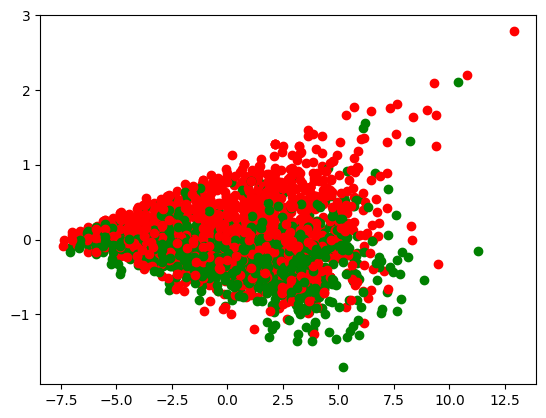

In [60]:
for i in range(len(principal_components)):
    if y[i] == 'y':
        plt.scatter(principal_components[i,0],principal_components[i,1],c='g')
    else:
        plt.scatter(principal_components[i,0],principal_components[i,1],c='r')

plt.show()

In [256]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(len(principal_components)):
    if y[i] == 'y':
        ax.scatter3D(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='g')
    else:
        ax.scatter3D(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='r')

plt.show()


KeyboardInterrupt



<IPython.core.display.Javascript object>


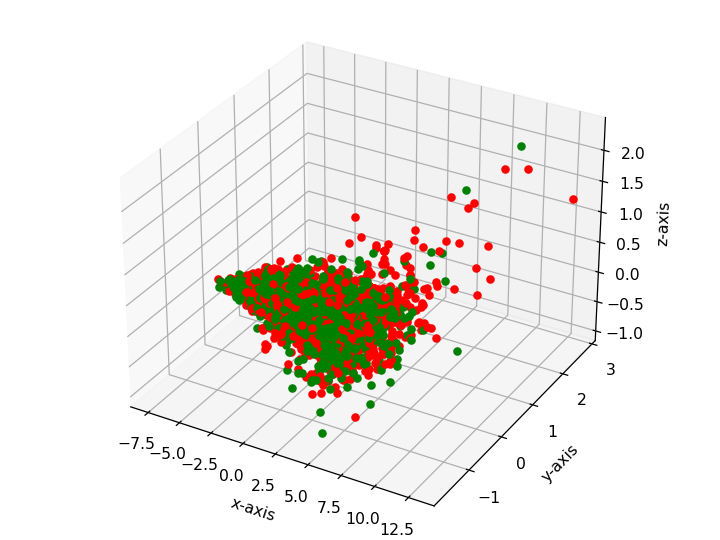

C:\Users\ana\AppData\Local\Temp\ipykernel_9376\2140900335.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [259]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = Axes3D(fig)
  
# creating the plot
# plot_geeks = ax.scatter(xs, ys, zs, color='green')

for i in range(len(principal_components)):
    if y[i] == 'y':
        ax.scatter(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='g')
    else:
        ax.scatter(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='r')
  
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis')
  
# displaying the plot
plt.show()

#### Checking classification results for reduced BERTweet vectors

In [19]:
num_of_components = [i for i in range(1,1024)]


accuracies = []
f1_scores = []
max_acc=(0,0)
max_f1=(0,0)

for num in num_of_components:
    pca = PCA(n_components=num)
    principal_components = pca.fit_transform(condensed_vector)

    train_size = int(0.8 * len(principal_components))
    x_train_bertweet_pca = principal_components[0:train_size]
    x_test_bertweet_pca = principal_components[train_size:]

    y_train_bertweet_pca = y[0:train_size]
    y_test_bertweet_pca = y[train_size:]

    clf_bertweet_pca = LogisticRegression(random_state=0).fit(x_train_bertweet_pca, y_train_bertweet_pca)
    y_pred_bertweet_pca_logreg = clf_bertweet_pca.predict(x_test_bertweet_pca)
    
    accuracy = accuracy_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg)
    accuracies.append(accuracy)
#     print(y_test_bertweet_pca)
#     print(y_pred_bertweet_pca_logreg)
    f1 = f1_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg,pos_label="y")
    f1_scores.append(f1)
    if f1 > max_f1[1]:
        max_f1 = (num, f1)
    if accuracy > max_acc[1]:
        max_acc = (num, accuracy)
#     print("Number of components:",num)
    
#     print(classification_report(y_test_bertweet_pca, y_pred_bertweet_pca_logreg))
#     print(accuracy_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg))
#     print(confusion_matrix(y_test_bertweet_pca, y_pred_bertweet_pca_logreg))

In [20]:
print(max_acc)
print(max_f1)

(137, 0.7980198019801981)
(137, 0.7660550458715597)


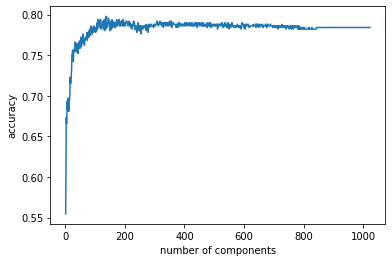

In [21]:
plt.plot(num_of_components[:len(accuracies) ],accuracies[:len(accuracies)])
plt.xlabel('number of components')
plt.ylabel('accuracy')
plt.show()

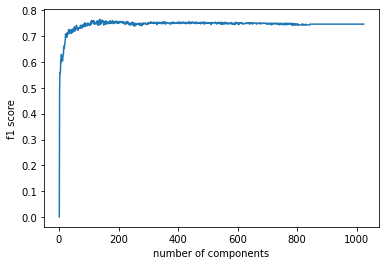

In [22]:
plt.plot(num_of_components[:len(accuracies)],f1_scores[:len(accuracies)])
plt.xlabel('number of components')
plt.ylabel('f1 score')
plt.show()

#### PCA with TF-IDF

In [28]:
def nospecial(text):
    import re
    text = re.sub("[^a-zA-Z0-9]+", " ",text)
    return text

only_english = []
for index, row in eng_tweets_csv.iterrows():
    only_english.append(nospecial(eng_tweets_csv.loc[index,'tweet_text'])) 

In [1]:
# import nltk
# nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [16]:
# import nltk
# from nltk.corpus import brown
# words = brown.words()

# only_eng_vocab = []

# progress = 0
# for sentence in only_english:
#     progress += 1
#     only_english.append(" ".join(w for w in nltk.wordpunct_tokenize(sentence) \
#          if w.lower() in words or not w.isalpha()))
#     if progress % 100 == 0:
#         print(progress)

# only_eng_vocab    


KeyboardInterrupt



In [29]:
no_stopwords = []
iter_num = 0
for sentence in only_english:
    iter_num += 1
    if iter_num % 500 == 0:
        print(iter_num)
    text_tokens = word_tokenize(sentence)

    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

    filtered_sentence = (" ").join(tokens_without_sw)
    no_stopwords.append(filtered_sentence)

500
1000


KeyboardInterrupt: 

In [51]:
vectorizer = TfidfVectorizer(min_df=50)
response = vectorizer.fit_transform(no_stopwords)
df_tfidf_sklearn = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
df_tfidf_sklearn

C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,about,all,an,and,anti,are,as,at,back,be,...,was,we,what,when,who,will,with,would,you,your
0,0.0,0.0,0.0,0.214788,0.000000,0.300047,0.000000,0.000000,0.0,0.000000,...,0.287333,0.000000,0.0,0.319653,0.000000,0.0,0.00000,0.0,0.652326,0.000000
1,0.0,0.0,0.0,0.234919,0.000000,0.000000,0.000000,0.335147,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.264084,...,0.000000,0.000000,0.0,0.303326,0.000000,0.0,0.00000,0.0,0.206336,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.308497,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.330137,0.0,0.00000,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.466744,0.000000,0.000000,0.000000,0.0,0.350991,...,0.000000,0.421188,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.274239,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.377207,0.000000,0.0,0.00000,0.0,0.256593,0.342200
2518,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,0.000000
2519,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.473026,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.40729,0.0,0.284241,0.000000
2520,0.0,0.0,0.0,0.000000,0.000000,0.276896,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.294989,0.000000,0.0,0.00000,0.0,0.401330,0.267613


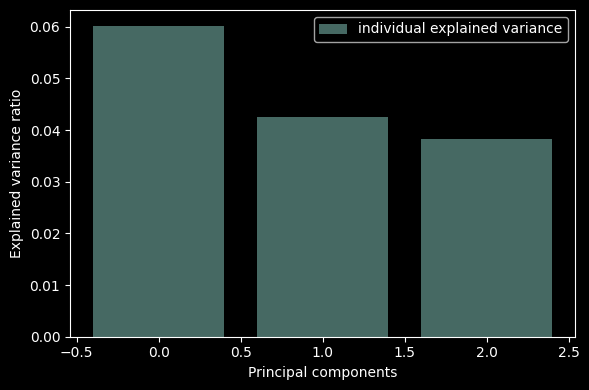

In [54]:
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_tfidf_sklearn)

explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(3), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

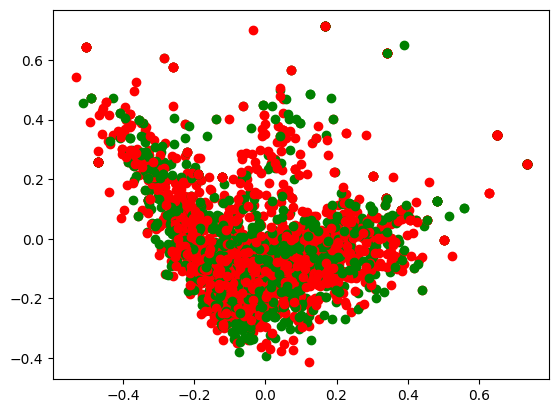

In [53]:
for i in range(len(principal_components)):
    if y[i] == 'y':
        plt.scatter(principal_components[i,0],principal_components[i,1],c='g')
    else:
        plt.scatter(principal_components[i,0],principal_components[i,1],c='r')

plt.show()

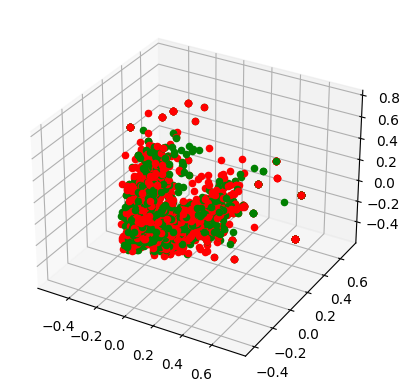

In [57]:
fig = plt.figure()
ax = plt.axes(projection='3d')

for i in range(len(principal_components)):
    if y[i] == 'y':
        ax.scatter3D(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='g')
    else:
        ax.scatter3D(principal_components[i,0], principal_components[i,1], principal_components[i,2], c='r')

plt.show()

In [37]:
n = 10

idx = np.argpartition((pca.components_.T[:,0]), -n)[-n:]
indices = idx[np.argsort((-(pca.components_.T[:,0]))[idx])]

for index in indices:
    print(df_tfidf_sklearn.columns[index],'-',pca.components_.T[:,0][index])

bully - 0.6925808720090638
user - 0.5139037460326533
lol - 0.11528105711550307
you - 0.0698359170582411
is - 0.05831953954186428
me - 0.05746918929685088
beatdown - 0.04356034229086015
lmao - 0.02088916606708777
big - 0.01712589812685958
im - 0.017103486161358285


In [38]:
idx = np.argpartition((pca.components_.T[:,1]), -n)[-n:]
indices = idx[np.argsort((-(pca.components_.T[:,1]))[idx])]

for index in indices:
    print(df_tfidf_sklearn.columns[index],'-',pca.components_.T[:,1][index])

httpurl - 0.6052118895137203
bullying - 0.44152089415121715
bully - 0.258675056331246
user - 0.1258817433426223
stop - 0.06967652351573629
anti - 0.06950409359430275
video - 0.06161940323202385
via - 0.05883805224944745
cyber - 0.047833325491451834
schools - 0.0475994329829569


In [30]:
min_df_list = [5, 10, 25, 40, 70, 100]
accuracies_list = []
f1_scores_list = []
num_of_components_list = []
first_components = 0.2

next_components = [0.5, 0.7, 0.85, 1]

for min_df in min_df_list:
    vectorizer = TfidfVectorizer(min_df=min_df)
    response = vectorizer.fit_transform(only_english)
    df_tfidf_sklearn = pd.DataFrame(response.toarray(),columns=vectorizer.get_feature_names())
    
    max_number_of_components = df_tfidf_sklearn.shape[1]
    
    num_of_first_components = int(first_components * max_number_of_components)
    
    
    next_components
    
    num_of_components = [i for i in range(1,num_of_first_components)]
    for next_component in next_components:
        num_of_components.append(int(next_component * max_number_of_components))
        
    
    num_of_components_list.append(num_of_components)
    accuracies = []
    f1_scores = []

    for num in num_of_components:
        pca = PCA(n_components=num)
        principal_components = pca.fit_transform(df_tfidf_sklearn)

        train_size = int(0.8 * len(principal_components))
        x_train_bertweet_pca = principal_components[0:train_size]
        x_test_bertweet_pca = principal_components[train_size:]

        y_train_bertweet_pca = y[0:train_size]
        y_test_bertweet_pca = y[train_size:]

        clf_bertweet_pca = LogisticRegression(random_state=0).fit(x_train_bertweet_pca, y_train_bertweet_pca)
        y_pred_bertweet_pca_logreg = clf_bertweet_pca.predict(x_test_bertweet_pca)

        accuracy = accuracy_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg)
        accuracies.append(accuracy)
    #     print(y_test_bertweet_pca)
    #     print(y_pred_bertweet_pca_logreg)
        f1 = f1_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg,pos_label="y")
        f1_scores.append(f1)
    accuracies_list.append(accuracies)
    f1_scores_list.append(f1_scores)

C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: 

min_df = 5


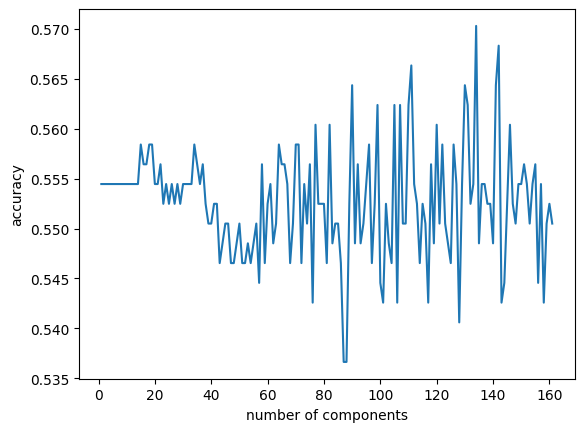

min_df = 10


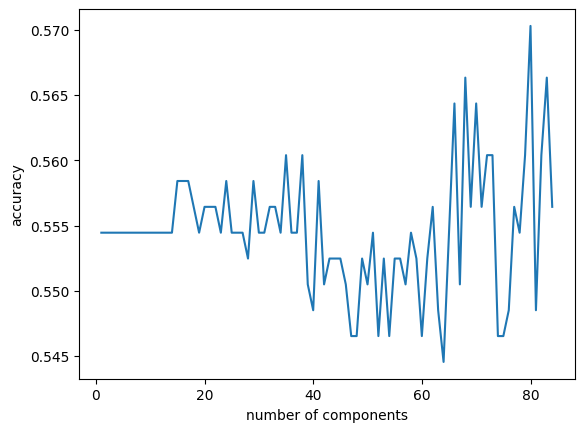

min_df = 25


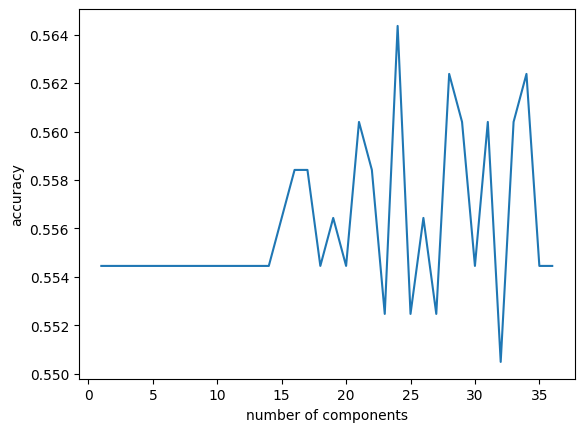

min_df = 40


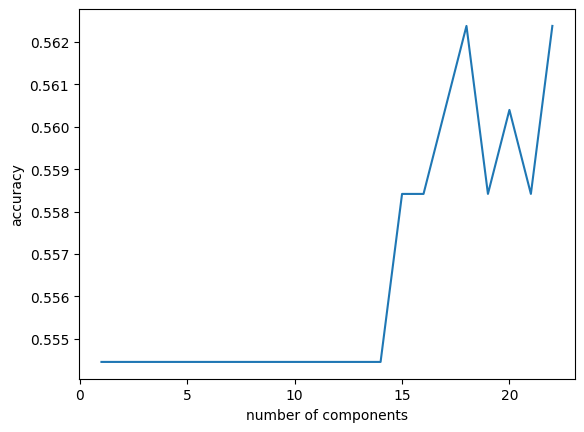

min_df = 70


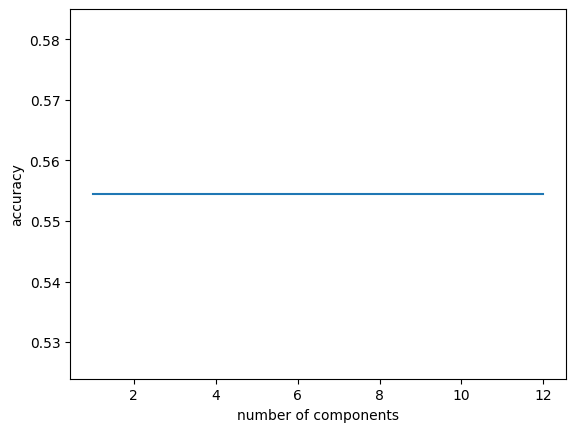

min_df = 100


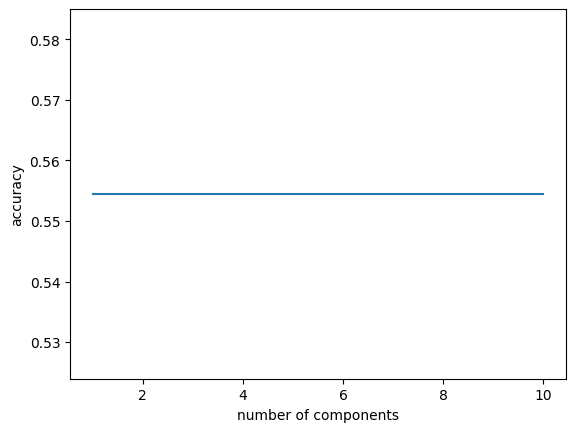

In [31]:
for i in range(len(accuracies_list)):
    print("min_df =", min_df_list[i])
    plt.plot(num_of_components_list[i][:len(accuracies_list[i]) - 4],accuracies_list[i][:len(accuracies_list[i]) - 4])
    plt.xlabel('number of components')
    plt.ylabel('accuracy')
    plt.show()

min_df = 5


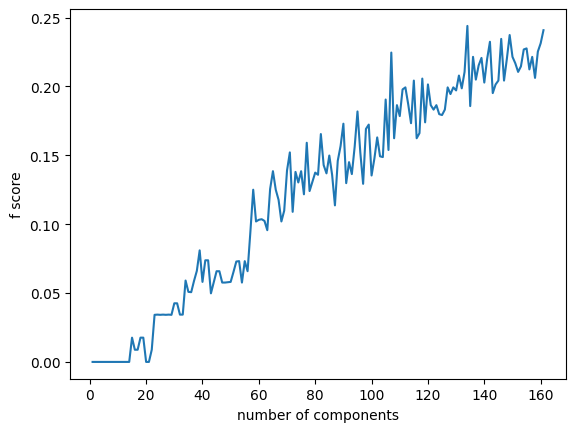

min_df = 10


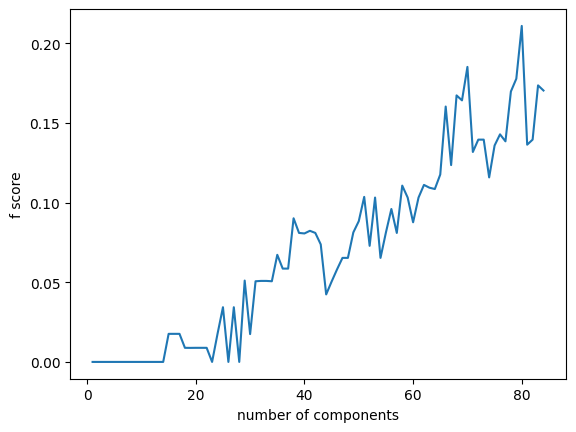

min_df = 25


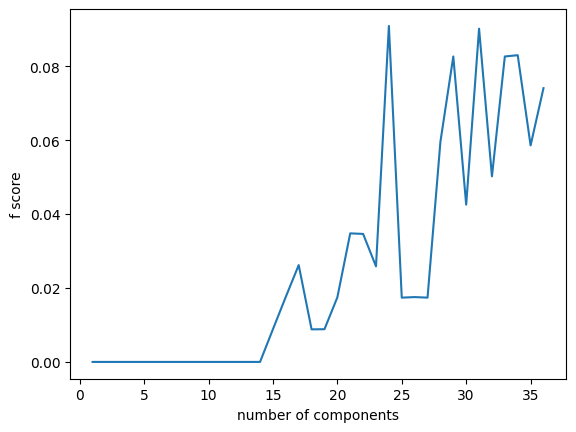

min_df = 40


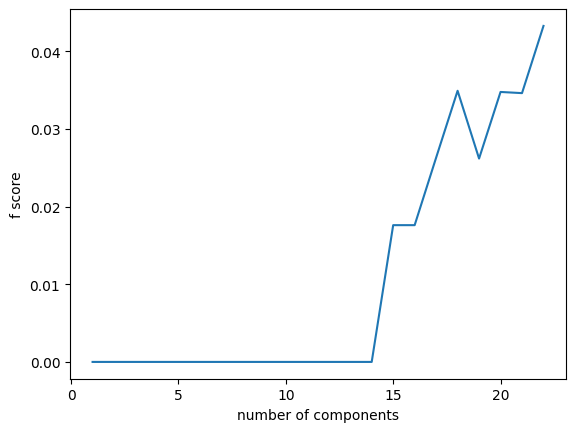

min_df = 70


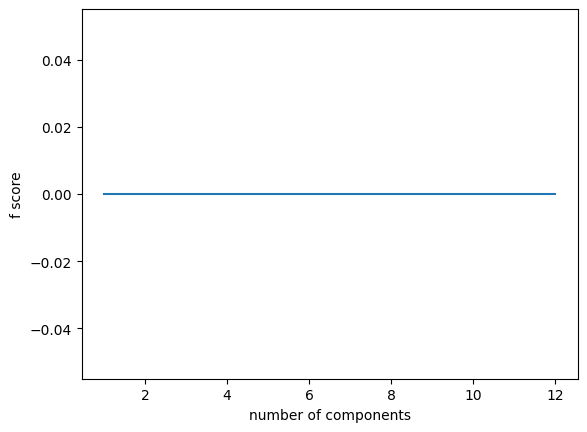

min_df = 100


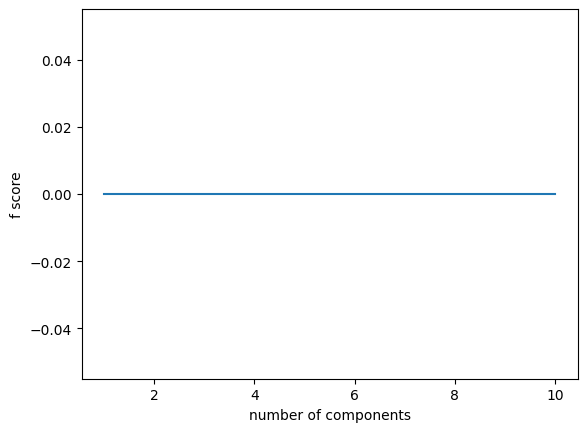

In [34]:
for i in range(len(f1_scores_list)):
    print("min_df =", min_df_list[i])
    plt.plot(num_of_components_list[i][:len(f1_scores_list[i]) - 4],f1_scores_list[i][:len(f1_scores_list[i]) - 4])
    plt.xlabel('number of components')
    plt.ylabel('f score')
    plt.show()

#### PCA with BOW

In [60]:
from sklearn.feature_extraction.text import CountVectorizer
CountVec = CountVectorizer(ngram_range=(1,2), # to use bigrams ngram_range=(2,2)
                           stop_words='english', min_df=50)
#transform
Count_data = CountVec.fit_transform(only_english)
 
#create dataframe
bow_csv=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names())
print(bow_csv)

      anti  big  bullied  bully  bullying  bullying httpurl  cyber  \
0        0    0        1      0         0                 0      0   
1        0    0        0      1         0                 0      0   
2        0    0        0      1         0                 0      0   
3        0    0        0      1         0                 0      0   
4        1    0        0      0         1                 0      0   
...    ...  ...      ...    ...       ...               ...    ...   
2517     0    0        1      0         0                 0      0   
2518     0    0        0      1         0                 0      0   
2519     0    0        0      1         0                 0      0   
2520     0    0        0      1         0                 0      0   
2521     0    0        1      0         0                 0      0   

      cyber bullying  did  getting  ...  love  people  school  stop  \
0                  0    0        0  ...     0       0       0     0   
1                

C:\Users\Mladen\miniconda3\envs\aipt\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


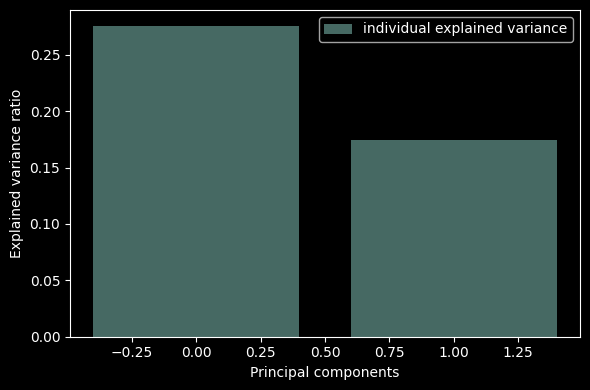

In [61]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(bow_csv)

explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(2), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

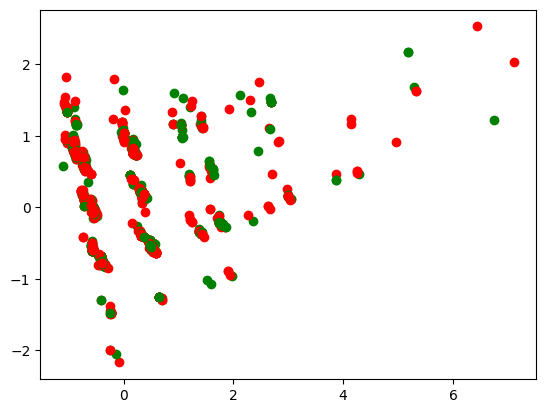

In [62]:
for i in range(len(principal_components)):
    if y[i] == 'y':
        plt.scatter(principal_components[i,0],principal_components[i,1],c='g')
    else:
        plt.scatter(principal_components[i,0],principal_components[i,1],c='r')

plt.show()

In [63]:
idx = np.argpartition((pca.components_.T[:,0]), -n)[-n:]
indices = idx[np.argsort((-(pca.components_.T[:,0]))[idx])]

for index in indices:
    print(bow_csv.columns[index],'-',pca.components_.T[:,0][index])

user - 0.8828372152283257
user user - 0.36955831759901936
bully - 0.156939945737279
lol - 0.05117660237419006
user bully - 0.04430894898690914
im - 0.01314774366375303
know - 0.010495201722203638
good - 0.008103768995636767
like - 0.00397989831457035
think - 0.0034717279090637977


In [64]:
idx = np.argpartition((pca.components_.T[:,1]), -n)[-n:]
indices = idx[np.argsort((-(pca.components_.T[:,1]))[idx])]

for index in indices:
    print(bow_csv.columns[index],'-',pca.components_.T[:,1][index])

bullying - 0.6167000895334759
user - 0.22208074264131927
httpurl - 0.1777696708066558
user user - 0.13062047250001588
stop - 0.09503942497703154
bullied - 0.0710610026176644
stop bullying - 0.06824754234447951
bullying httpurl - 0.0558441434693546
school - 0.05180256622290772
anti - 0.0388699981401391


### DOC2VEC

In [35]:
tokenized_sent = []
for s in only_english:
    tokenized_sent.append(word_tokenize(s.lower()))

tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_sent)]

model = Doc2Vec(tagged_data, vector_size = 20, window = 2, min_count = 5, epochs = 100)

In [36]:
doc2vec_vectors = []
iter_num = 0
for each in tokenized_sent:
    if iter_num % 500 == 0:
        print(iter_num)
    iter_num += 1
    doc2vec_vectors.append(model.infer_vector(each))

0
500
1000
1500
2000
2500


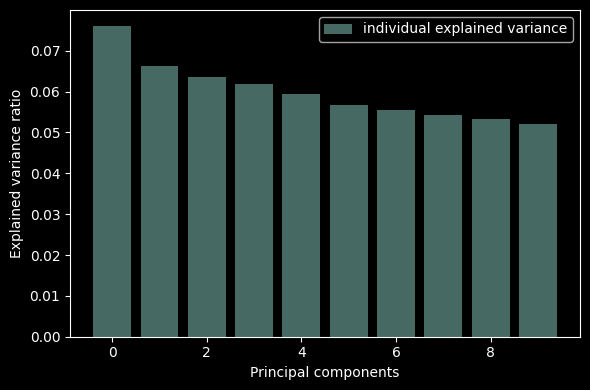

In [37]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(doc2vec_vectors)

explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

0
500
1000
1500
2000
2500


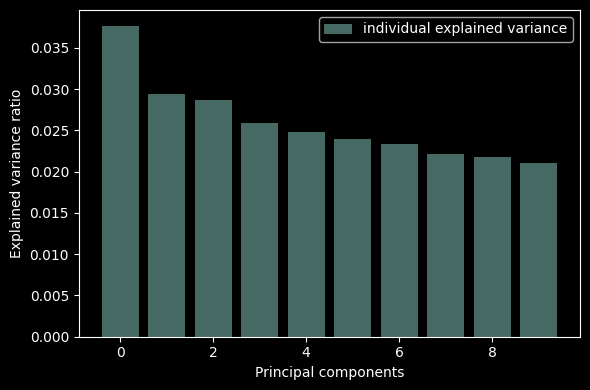

In [39]:
model = Doc2Vec(tagged_data, vector_size = 1024, window = 2, min_count = 50, epochs = 1000)

doc2vec_vectors = []
iter_num = 0
for each in tokenized_sent:
    if iter_num % 500 == 0:
        print(iter_num)
    iter_num += 1
    doc2vec_vectors.append(model.infer_vector(each))
    
    
pca = PCA(n_components=10)
principal_components = pca.fit_transform(doc2vec_vectors)

explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

### UNIVERSAL SENTENCE ENCODER

In [23]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" 
model = hub.load(module_url)
print ("module %s loaded" % module_url)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [24]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [25]:
sentences = eng_tweets_csv['tweet_text']
sentence_embeddings = model(sentences)

In [26]:
train_size = int(0.8 * len(eng_tweets_csv))
test_size = len(eng_tweets_csv) - train_size

x_train = model(sentences[0:train_size])
x_test = model(sentences[train_size:])

y_train = eng_tweets_csv['bullying_traces'][0:train_size]
y_test = eng_tweets_csv['bullying_traces'][train_size:]

#### Logistic regression

In [204]:
clf = LogisticRegression(random_state=0).fit(x_train, y_train)

In [205]:
y_pred_logReg = clf.predict(x_test)
print(classification_report(y_test, y_pred_logReg))
print(accuracy_score(y_test, y_pred_logReg))
print(confusion_matrix(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           n       0.77      0.85      0.81       281
           y       0.79      0.69      0.74       224

    accuracy                           0.78       505
   macro avg       0.78      0.77      0.77       505
weighted avg       0.78      0.78      0.78       505

0.7801980198019802
[[240  41]
 [ 70 154]]


#### XGBoost

In [246]:
y_train_xgb = []
y_test_xgb = []
for i in range(len(y_train)):
    if i < len(y_test):
        if y_test[i + train_size] == 'y':
            y_test_xgb.append(1)
        else:
            y_test_xgb.append(0)
        
    if y_train[i] == 'y':
        y_train_xgb.append(1)
    else:
        y_train_xgb.append(0)

In [247]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [248]:
ypred = xgb_cl.predict(x_test)
print(classification_report(y_test_xgb, ypred))
print(accuracy_score(y_test_xgb, ypred))
print(confusion_matrix(y_test_xgb, ypred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.81       281
           1       0.78      0.69      0.73       224

    accuracy                           0.77       505
   macro avg       0.77      0.77      0.77       505
weighted avg       0.77      0.77      0.77       505

0.7742574257425743
[[237  44]
 [ 70 154]]
0.7298578199052133


#### KNN

In [264]:
n_neighbors = 10
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [266]:
ypred = clf.predict(x_test)
print(classification_report(y_test, ypred))
print(accuracy_score(y_test, ypred))
print(confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           n       0.84      0.70      0.76       281
           y       0.69      0.84      0.76       224

    accuracy                           0.76       505
   macro avg       0.77      0.77      0.76       505
weighted avg       0.78      0.76      0.76       505

0.7603960396039604
[[196  85]
 [ 36 188]]


#### PCA with universal sentence encoder

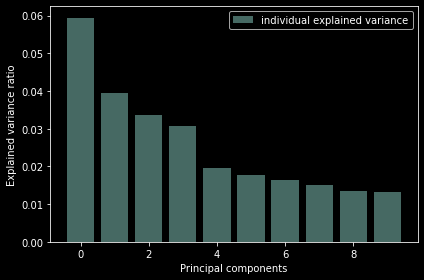

In [29]:
lista = []

for i in sentences:
    lista.append(model([i])[0])
    
pca = PCA(n_components=10)
principal_components = pca.fit_transform(lista)


explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [30]:
num_of_components = [i for i in range(1,512)]

accuracies = []
f1_scores = []
max_acc = (0,0) # prvo je broj komponenata, drugo vrijednost accuracy
max_f1 = (0,0) #
for num in num_of_components:
    pca = PCA(n_components=num)
    principal_components = pca.fit_transform(lista)

    train_size = int(0.8 * len(principal_components))
    x_train_bertweet_pca = principal_components[0:train_size]
    x_test_bertweet_pca = principal_components[train_size:]

    y_train_bertweet_pca = eng_tweets_csv["bullying_traces"][0:train_size]
    y_test_bertweet_pca = eng_tweets_csv["bullying_traces"][train_size:]

    clf_bertweet_pca = LogisticRegression(random_state=0).fit(x_train_bertweet_pca, y_train_bertweet_pca)
    y_pred_bertweet_pca_logreg = clf_bertweet_pca.predict(x_test_bertweet_pca)
    
    accuracy = accuracy_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg)
    accuracies.append(accuracy)
#     print(y_test_bertweet_pca)
#     print(y_pred_bertweet_pca_logreg)
    f1 = f1_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg,pos_label="y")
    f1_scores.append(f1)
    if f1 > max_f1[1]:
        max_f1 = (num, f1)
    if accuracy > max_acc[1]:
        max_acc = (num, accuracy)

In [31]:
# optimalan broj komponenata:

In [32]:
print(max_acc)
print(max_f1)

(96, 0.7940594059405941)
(96, 0.75)


In [33]:
print(lista[0].shape)

(512,)


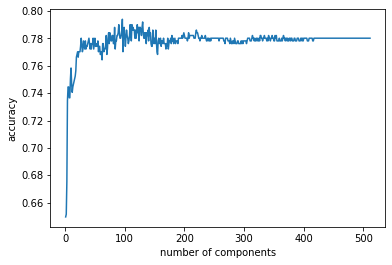

In [34]:
plt.plot(num_of_components[:len(accuracies) ],accuracies[:len(accuracies)])
plt.xlabel('number of components')
plt.ylabel('accuracy')
plt.show()

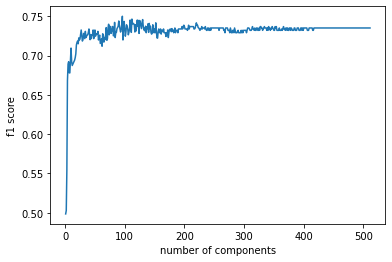

In [35]:
plt.plot(num_of_components[:len(accuracies)],f1_scores[:len(accuracies)])
plt.xlabel('number of components')
plt.ylabel('f1 score')
plt.show()

### INFERSENT

In [27]:
# download models.py from: https://github.com/facebookresearch/InferSent/blob/main/models.py

#  mkdir encoder
#  curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl
  
#  mkdir GloVe
#  curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
#  unzip GloVe/glove.840B.300d.zip -d GloVe/

In [206]:
from models import InferSent
import torch
import nltk
nltk.download('punkt')

sentences = eng_tweets_csv['tweet_text']

V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
model_is = InferSent(params_model)
model_is.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = './GloVe/glove.840B.300d/glove.840B.300d.txt'
model_is.set_w2v_path(W2V_PATH)
lista=[]
model_is.build_vocab(sentences, tokenize=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 6806(/7429) words with w2v vectors
Vocab size : 6806


In [40]:
train_size = int(0.8 * len(eng_tweets_csv))
test_size = len(eng_tweets_csv) - train_size

x_train = model.encode(eng_tweets_csv['tweet_text'][0:train_size])
x_test = model.encode(eng_tweets_csv['tweet_text'][train_size:])

y_train = eng_tweets_csv['bullying_traces'][0:train_size]
y_test = eng_tweets_csv['bullying_traces'][train_size:]

#### Logistic regression

In [41]:
clf = LogisticRegression(random_state=100).fit(x_train, y_train)

C:\Users\ana\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
y_pred_logReg = clf.predict(x_test)
print(classification_report(y_test, y_pred_logReg))
print(accuracy_score(y_test, y_pred_logReg))
print(confusion_matrix(y_test, y_pred_logReg))

              precision    recall  f1-score   support

           n       0.75      0.80      0.77       281
           y       0.72      0.66      0.69       224

    accuracy                           0.74       505
   macro avg       0.73      0.73      0.73       505
weighted avg       0.74      0.74      0.74       505

0.7366336633663366
[[224  57]
 [ 76 148]]


#### XGBoost

In [45]:
y_train_xgb = []
y_test_xgb = []
for i in range(len(y_train)):
    if i < len(y_test):
        if y_test[i + train_size] == 'y':
            y_test_xgb.append(1)
        else:
            y_test_xgb.append(0)
        
    if y_train[i] == 'y':
        y_train_xgb.append(1)
    else:
        y_train_xgb.append(0)

In [47]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(x_train, y_train_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [48]:
ypred = xgb_cl.predict(x_test)
print(classification_report(y_test_xgb, ypred))
print(accuracy_score(y_test_xgb, ypred))
print(confusion_matrix(y_test_xgb, ypred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       281
           1       0.74      0.66      0.70       224

    accuracy                           0.75       505
   macro avg       0.75      0.74      0.74       505
weighted avg       0.75      0.75      0.75       505

0.7485148514851485
[[230  51]
 [ 76 148]]


#### KNN

In [108]:
n_neighbors = 100
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=100, weights='distance')

In [109]:
ypred = clf.predict(x_test)
print(classification_report(y_test, ypred))
print(accuracy_score(y_test, ypred))
print(confusion_matrix(y_test, ypred))

              precision    recall  f1-score   support

           n       0.84      0.58      0.68       281
           y       0.62      0.86      0.72       224

    accuracy                           0.70       505
   macro avg       0.73      0.72      0.70       505
weighted avg       0.74      0.70      0.70       505

0.7029702970297029
[[163 118]
 [ 32 192]]


#### PCA with Infersent

In [207]:
lista = []
for i in sentences:
    lista.append(model_is.encode(i)[0])

C:\Users\ana\Desktop\apt4.6\AIPT\projekt\models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


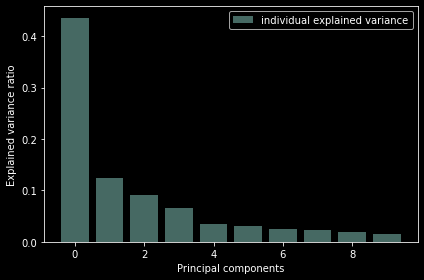

In [208]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(lista)

explained_variance=pca.explained_variance_ratio_

with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(10), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [209]:
num_of_components = [i for i in range(1,201)]
num_of_components.append(300)
num_of_components.append(512)
num_of_components.append(1024)
num_of_components.append(2522)

accuracies = []
f1_scores = []

for num in num_of_components:
    pca = PCA(n_components=num)
    principal_components = pca.fit_transform(lista)

    train_size = int(0.8 * len(principal_components))
    x_train_bertweet_pca = principal_components[0:train_size]
    x_test_bertweet_pca = principal_components[train_size:]

    y_train_bertweet_pca = eng_tweets_csv["bullying_traces"][0:train_size]
    y_test_bertweet_pca = eng_tweets_csv["bullying_traces"][train_size:]

    clf_bertweet_pca = LogisticRegression(random_state=0).fit(x_train_bertweet_pca, y_train_bertweet_pca)
    y_pred_bertweet_pca_logreg = clf_bertweet_pca.predict(x_test_bertweet_pca)
    
    accuracy = accuracy_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg)
    accuracies.append(accuracy)
#     print(y_test_bertweet_pca)
#     print(y_pred_bertweet_pca_logreg)
    f1 = f1_score(y_test_bertweet_pca, y_pred_bertweet_pca_logreg,pos_label="y")
    f1_scores.append(f1)

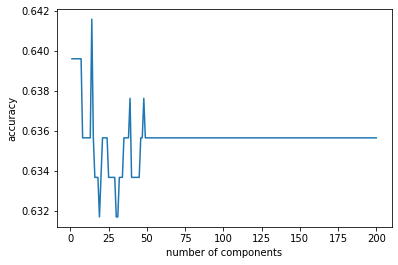

In [210]:
plt.plot(num_of_components[:len(accuracies) - 4],accuracies[:len(accuracies) - 4])
plt.xlabel('number of components')
plt.ylabel('accuracy')
plt.show()

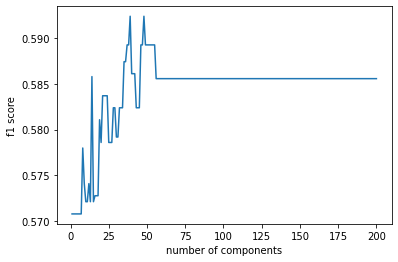

In [211]:
plt.plot(num_of_components[:len(accuracies) - 4],f1_scores[:len(accuracies) - 4])
plt.xlabel('number of components')
plt.ylabel('f1 score')
plt.show()